# <a id='head'>Содержание проекта</a>
<a href='#01'>Условие задачи</a>   
<a href='#02'>Описание этапа обработки</a>  
<a href='#03'>Описание данных</a>  
<a href='#04'>import</a> 

1. <a href='#1'>Первичный анализ данных</a>
2. <a href='#2'>План работы</a>
3. <a href='#3'>Исследовательский анализ данных</a> 
 1. <a href='#3.1'>data_arc</a> 
 2. <a href='#3.2'>data_bulk</a>  
 3. <a href='#3.3'>data_gas</a> 
 4. <a href='#3.4'>data_temp</a> 
 5. <a href='#3.5'>data_wire</a>
 6. <a href='#3.6'>data_wire_time, data_bulk_time</a>
4. <a href='#4'>Объединение таблиц</a> 
5. <a href='#5'>Значимость признаков</a> 
6. <a href='#6'>Обучение моделей</a> 
 1. <a href='#6.1'>Классические модели</a> 
 2. <a href='#6.2'>LightGBM</a> 
 3. <a href='#6.3'>CatBoost</a>
 
7. <a href='#7'>Отчет</a>  

## <a id='01'>Условие задачи</a> 
<a href='#head'>[head]</a>

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали. </br>  
Целевая метрика MAE ≤ 6.0

## <a id='02'>Описание этапа обработки</a> 
<a href='#head'>[head]</a>

Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами.

Добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

## <a id='03'>Описание данных</a> 
<a href='#head'>[head]</a>

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## <a id='04'>import</a> 
<a href='#head'>[head]</a>

In [7]:
import pandas as pd
import numpy as np
from IPython.display import display
import glob
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

## <a id='1'>1. Первичный анализ данных</a> 
<a href='#head'>[head]</a>

In [8]:
def create_df_from_csv_in_folder(way):
    a = glob.glob(way)
    count = 0
    for i in way:
        count += 1
    csv_name = []  
    for n in range(len(a)):
        csv_name.append(a[n][count-1:-4])
    datasets = csv_name.copy()
    for x in range(len(a)):
        datasets[x] = pd.read_csv(a[x])
    for x,y in zip(csv_name, datasets):
        globals()[x] = y
    return csv_name

def df_info(csv_name):
    for i in range(len(csv_name)):
        print(csv_name[i])
        globals().get(csv_name[i]).info()
        display(globals().get(csv_name[i]).head())
        print()

Выведем названия датасетов - csv-файлов.

In [9]:
way1 = 'C:\\Users\\1\\steel\\*'
way2 = '/datasets/final_steel/*'
way3 = 'C:\\Users\\К\\Desktop\\Проекты\\steel\\csv_files\\*'

In [10]:
csv_name = create_df_from_csv_in_folder(way2)

if len(csv_name) == 0:
    csv_name = create_df_from_csv_in_folder(way1)
    if len(csv_name) == 0:
        csv_name = create_df_from_csv_in_folder(way3)

print(csv_name)

['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']


Восопльзуемся функцией df_info() для первичного анализа имеющихся данных.

In [11]:
df_info(csv_name)

data_arc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



data_bulk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



data_bulk_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



data_gas
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



data_temp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



data_wire
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



data_wire_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- `data_arc`(данные об электродах): пропущенные значения отсутствуют, имеются данные несоответствующие своему типу (#1,2)
- `data_bulk`(объём подачи сыпучих материалов): на первый взгляд всё в порядке 
- `data_bulk_time`(время подачи сыпучих материалов): необходимо привести данные к своему типу (#1-15)
- `data_gas`(данные о продувке сплава газом): всё на месте
- `data_temp`(результаты измерения температуры): необходимо привести данные к своему типу (#1), имеются пропуски замеров, но возможно это соответствует действительности
- `data_wire`(объём проволочных материалов): всё на месте
- `data_wire_time`(время подачи проволочных материалов): необходимо привести данные к своему типу (#1-9)

Все признаки у нас численные. Имеются пропуски.

## <a id='2'>2. План работы</a> 
<a href='#head'>[head]</a>

1. Выполнить предобработку данных (заполнить пропуски, привести данные к своему типу).
2. Проанализировать возможность выявления новых признаков (посмотреть какие из признаков можно объеденить, преобразовать).
3. Выбрать признаки, которые будут участвовать в обучении (есть признаки, не играющие роли в обучении модели).
4. Проанализировать распределение, наличие выбросов у признаков, принять решение об участии выбросов(в случае их наличия) в обучении модели.
5. Обучить классические модели регрессии, выбрать лучшую по дефолтным настройкам, подобрать гиперпараметры для лучшей. Обучить модели CatBoost, LightGBM, подобрать гиперпараметры.
6. Выбрать наиболее подходящую по метрике, в случае неудачи вернуться к пункту 3.
7. Сделать выводы, написать отчет.

Приведем данные из выбранных датасетов к их формату.

In [12]:
column_keys=['Начало', 'Конец', 'Время', 'Wire', 'Bulk']
def time_columns_transform(df):
    for col in df.columns:
        for key in column_keys: 
            if key in col:
                df[col] = pd.to_datetime(df[col], format = '%Y-%m-%d %H:%M:%S')
                df[col] = df[col].sort_values(ascending = True)

In [13]:
time_columns_transform(data_arc)
time_columns_transform(data_bulk_time)
time_columns_transform(data_temp)
time_columns_transform(data_wire_time)

Теперь проанализируем каждый датасет отдельно.

## <a id='3'>3. Исследовательский анализ данных</a> 
<a href='#head'>[head]</a>

## <a id='3.1'>data_arc</a> 
<a href='#head'>[head]</a>

Преобразуем признаки в таблице об электродах.

In [14]:
#считаем дельту по секундам
data_arc['delta'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
data_arc['seconds_delta'] = data_arc['delta']

#находим разницу и переводим в числовой формат
for i in range(len(data_arc['delta'])):
    data_arc['seconds_delta'][i] = data_arc['delta'][i].seconds
data_arc['seconds_delta']=pd.to_numeric(data_arc['seconds_delta']).copy()

#вычисляем кол-во выделенного за промежуток времени тепла
data_arc['heat'] = data_arc['Активная мощность']*data_arc['seconds_delta']

#объединяем по номеру партии
data_arc_model = pd.pivot_table((data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 
                                'Реактивная мощность', 'delta'], axis = 1)), index = 'key', aggfunc = 'sum')
data_arc_model.columns = ['heat', 'heating_time', 'power']

data_arc_model

,heat,heating_time,power
key,,,
1,1207.804249,1098,4.878147
2,733.816470,811,3.052598
3,443.583327,655,2.525882
4,670.663327,741,3.209250
5,997.496095,869,3.347173
...,...,...,...
3237,777.993447,909,3.932467
3238,432.849310,546,2.106529
3239,844.977151,1216,4.666754


3214 строк от 1 до 3241, судя по всему в части партий электроды не задействовали и температуру не меняли.</br>  
Посмотрим на диаграммы рассеяния.

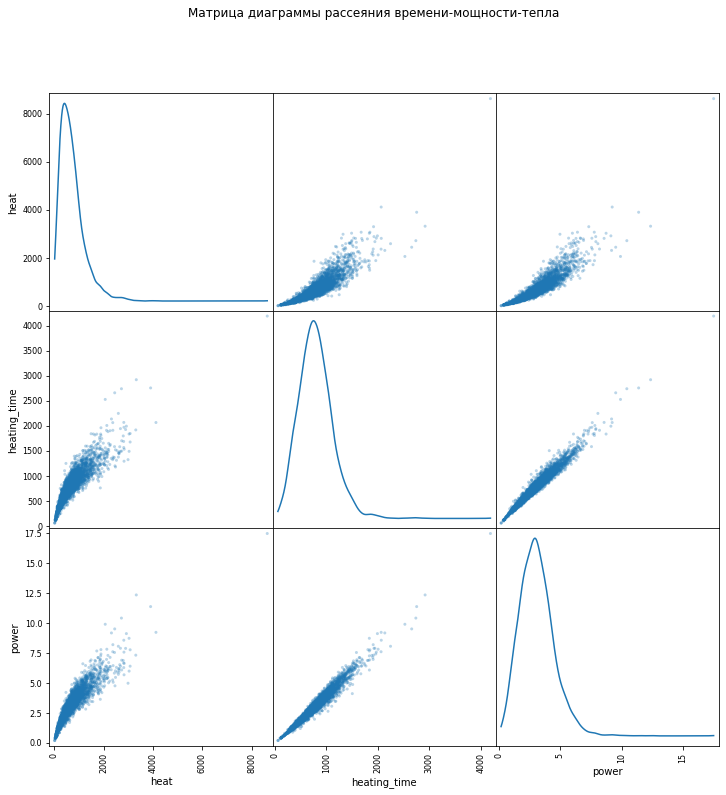

In [15]:
pd.plotting.scatter_matrix(data_arc_model, figsize=(12, 12), alpha=0.3, diagonal='kde')
plt.suptitle('Матрица диаграммы рассеяния времени-мощности-тепла')
plt.show()

Судя по графикам распределения каждого признака имеется небольшая часть каждого признака, скошенная вправо. Имеющиеся выбросы - выбросы или часть технологического процесса для редких видов сплава? Попробуем оба варианта.

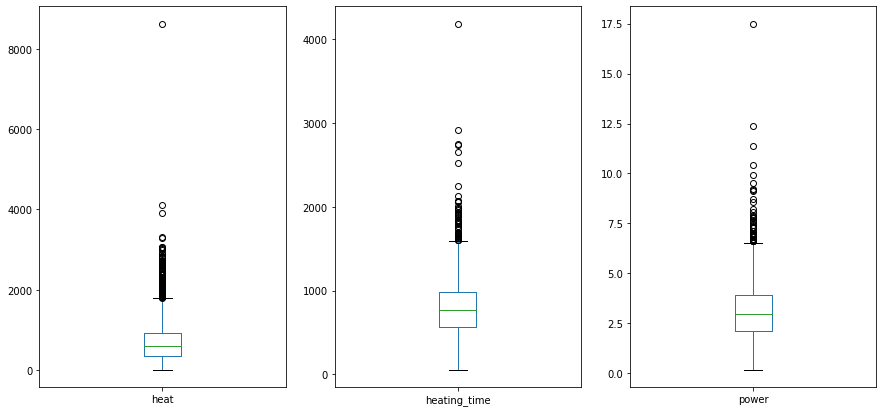

In [16]:
data_arc_model.plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(15, 7))
plt.show()

In [17]:
def cutter(df):
    data = df.describe()
    for i in df:
        df = df[df[i] < (data[i]['75%'] + 1.5 * (data[i]['75%'] - data[i]['25%']))]

    return df

In [18]:
data_arc_model_cutter = cutter(data_arc_model)

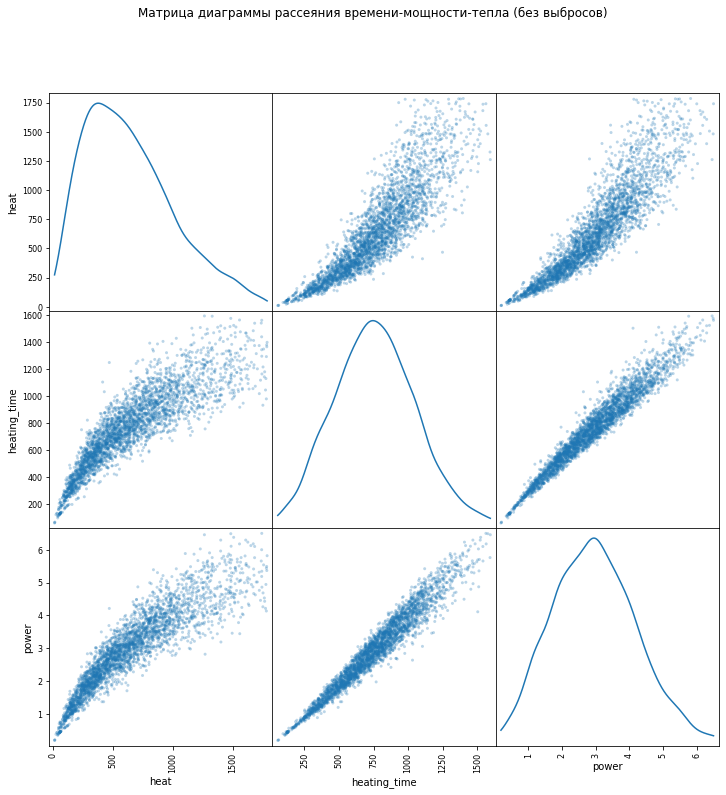

In [19]:
pd.plotting.scatter_matrix(data_arc_model_cutter, figsize=(12, 12), alpha=0.3, diagonal='kde')
plt.suptitle('Матрица диаграммы рассеяния времени-мощности-тепла (без выбросов)')
plt.show()

Мы получили два варината датасетов с выбросами и без.

## <a id='3.2'>data_bulk</a> 
<a href='#head'>[head]</a>

In [20]:
data_bulk.set_index('key', inplace = True)
data_bulk

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0


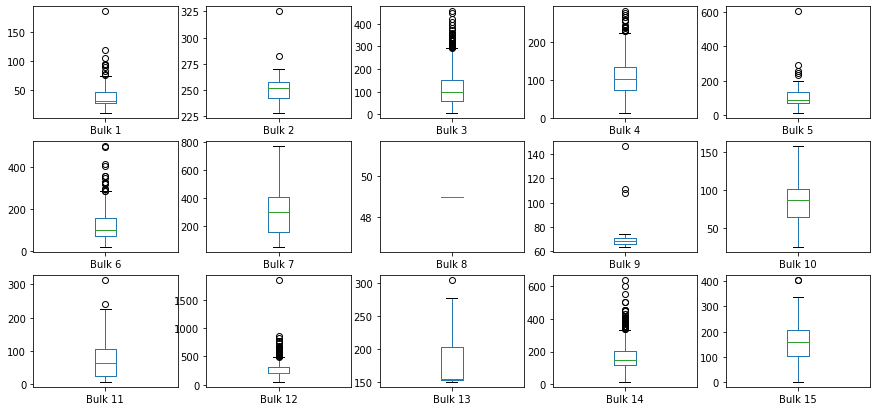

In [21]:
data_bulk.plot(kind='box', subplots=True, layout=(3,5), sharex=False, sharey=False, figsize=(15, 7))
plt.show()

Судя по всему имеется некоторое количество выбросов.

In [22]:
len(cutter(data_bulk))

0

Мы можем убрать выбросы из конкретного столбца и таблица уменьшится, но если уберем все выбросы, то они перекроют все партии, слишком много столбцов. Возможно это специфика того или иного сплава.
3129 строк от 1 до 3241, как и в прошлой таблице в часть партий не подавали сыпучие материалы.

In [23]:
data_bulk = data_bulk.fillna(0) #так как считаем что объем отсутствующей подачи равен 0

## <a id='3.3'>data_gas</a> 
<a href='#head'>[head]</a>

In [24]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas'})

In [25]:
data_gas.set_index('key', inplace = True)
data_gas

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


## <a id='3.4'>data_temp</a> 
<a href='#head'>[head]</a>

Необходимо разбить на признак(первое вхождение) и целевой(последнее вхождение) признаки.

In [26]:
data_temp_pivot = data_temp.pivot_table(index = 'key', values='Температура', aggfunc ='count')
data_temp_pivot

,Температура
key,
1,5
2,6
3,5
4,3
5,2
...,...
3237,1
3238,1
3239,1


Есть партии в которых замер температуры производился один раз, для них первое вхождение и будет целевой признак? То есть идеальная температура достигнута сразу. Но тогда нет смысла добавлять легирующие добавки, и соответственно взаимосвязи нет и эти признаки нам не интересны.

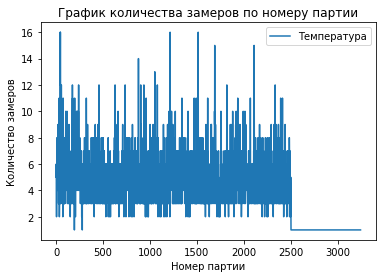

In [27]:
data_temp_pivot.plot()
plt.title('График количества замеров по номеру партии')
plt.ylabel('Количество замеров')
plt.xlabel('Номер партии')
plt.show()

Судя по графику, количество замеров упадет после порога в 2500, это львиная доля наших партий и данных. Взглянем на хвост датасета, если один замер - это следствие одной итерации в партии, тогда это первый и последний замер, и соответственно не целевой признак, в другом случае у нас производится первый замер и нет данных последнего замера и такой замер целевым признаком также не является.

In [28]:
data_temp.tail(30)

,key,Время замера,Температура
15877,3236,2019-08-31 22:31:42,NaN
15878,3237,2019-08-31 22:44:04,1569.0
15879,3237,2019-08-31 22:44:44,NaN
15880,3237,2019-08-31 22:51:02,NaN
15881,3237,2019-08-31 23:01:16,NaN
15882,3237,2019-08-31 23:05:43,NaN
15883,3238,2019-08-31 23:30:31,1584.0
15884,3238,2019-08-31 23:37:26,NaN
15885,3238,2019-08-31 23:43:00,NaN
15886,3239,2019-09-01 01:31:47,1598.0


Выходит, в части партий производился только первый замер, а последующие данные отсутствуют, ввиду отсутствия целевого признака в этих партиях, нам придется их отбросить. Но сначала проверим, нет ли у нас партий с одним единственным замером.

In [29]:
count_temp_iter = data_temp.pivot_table(index = 'key', values='Время замера', aggfunc ='count')
drop_keys = list((((count_temp_iter[count_temp_iter['Время замера'] < 2]).index)))
print(drop_keys)

[195, 279]


195 и 279 партии замерялись один раз - первый, их также непобходимо исключить.

In [30]:
temp_iterations = len(data_temp['key'].unique()) 

In [31]:
data_temp_feature = data_temp.copy()
data_temp_feature = data_temp_feature.drop_duplicates(subset = 'key', keep = 'first').reset_index(drop = True)
data_temp_feature.set_index('key', inplace = True)
data_temp_feature.index = data_temp_feature.index.astype(int)
data_temp_feature = data_temp_feature.drop(['Время замера'], axis =1)
data_temp_feature = data_temp_feature.drop(drop_keys, axis=0)
data_temp_feature = data_temp_feature.rename(columns={'Температура': 't_feature'})
data_temp_feature

,t_feature
key,
1,1571.0
2,1581.0
3,1596.0
4,1601.0
5,1576.0
...,...
3237,1569.0
3238,1584.0
3239,1598.0


Аналогично создаем целевой признак.

In [32]:
data_target = data_temp.copy()
data_target = data_target.drop_duplicates(subset = 'key', keep = 'last').reset_index(drop = True)
data_target.set_index('key', inplace = True)
data_target.index = data_target.index.astype(int)
data_target = data_target.drop(['Время замера'], axis =1)
data_target = data_target.drop(drop_keys, axis=0)
data_target = data_target.rename(columns={'Температура': 't_target'})
data_target

,t_target
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
3237,NaN
3238,NaN
3239,NaN


Часть финальных замеров отсутствует, поскольку их отсутствие нам ни о чем не говорит, а они являются целевым признаком, избавимся от отсутствующих значений.

In [33]:
data_target = data_target.dropna()
data_target

,t_target
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
2495,1591.0
2496,1591.0
2497,1589.0


## <a id='3.5'>data_wire</a> 
<a href='#head'>[head]</a>

In [34]:
data_wire.set_index('key', inplace = True)
data_wire

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


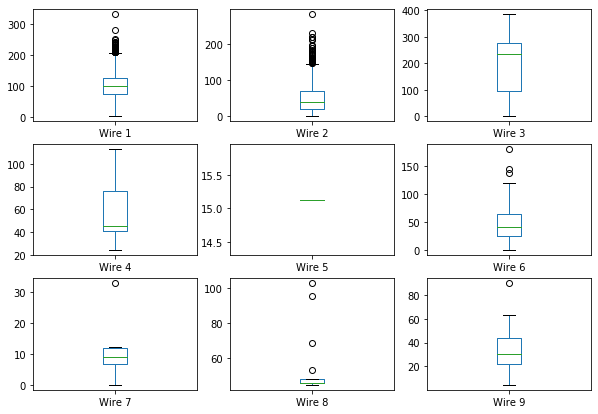

In [35]:
data_wire.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10, 7))
plt.show()

In [36]:
len(cutter(data_wire))

0

Ситуация такая же, как и с data_bulk, выбросы есть, но мы не можем избавиться от всех, оставляем как часть уникальности технологического процесса для определенных видов сплава.

In [37]:
data_wire = data_wire.fillna(0) #так как считаем что объем отсутствующей подачи равен 0
data_wire

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Судя по количеству строк, часть партий также обошлась без добавления проволочных материалов.

## <a id='3.6'>data_wire_time, data_bulk_time</a> 
<a href='#head'>[head]</a>

data_wire_time, data_bulk_time сообщают нам о времени подачи добавок, изначально предполагаем, что время подачи материала не играет роли, так как является не причиной, а сопутствующим следствием необходимости подавать добавки по факту замера температуры. 

## <a id='4'>4. Объединение таблиц</a> 
<a href='#head'>[head]</a>

Для начала попробуем полную неурезанную версию.

In [38]:
df_prom = (
    data_target.join(data_arc_model, how = 'left')
    .join(data_bulk, how = 'left')
    .join(data_wire, how = 'left')
    .join(data_gas, how = 'left')
    .join(data_temp_feature, how = 'left')
)

In [39]:
df_prom = df_prom.fillna(0)
df_prom

,t_target,heat,heating_time,power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas,t_feature
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1207.804249,1098,4.878147,0.0,0.0,0.0,43.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0
2,1602.0,733.816470,811,3.052598,0.0,0.0,0.0,73.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0
3,1599.0,443.583327,655,2.525882,0.0,0.0,0.0,34.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0
4,1625.0,670.663327,741,3.209250,0.0,0.0,0.0,81.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0
5,1602.0,997.496095,869,3.347173,0.0,0.0,0.0,78.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1591.0,626.167357,723,3.210690,0.0,0.0,21.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1570.0
2496,1591.0,727.868032,940,4.203064,0.0,0.0,0.0,63.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1554.0
2497,1589.0,427.535518,569,2.212379,0.0,0.0,0.0,85.0,0.0,0.0,...,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1571.0


## <a id='5'>5. Значимость признаков</a> 
<a href='#head'>[head]</a>

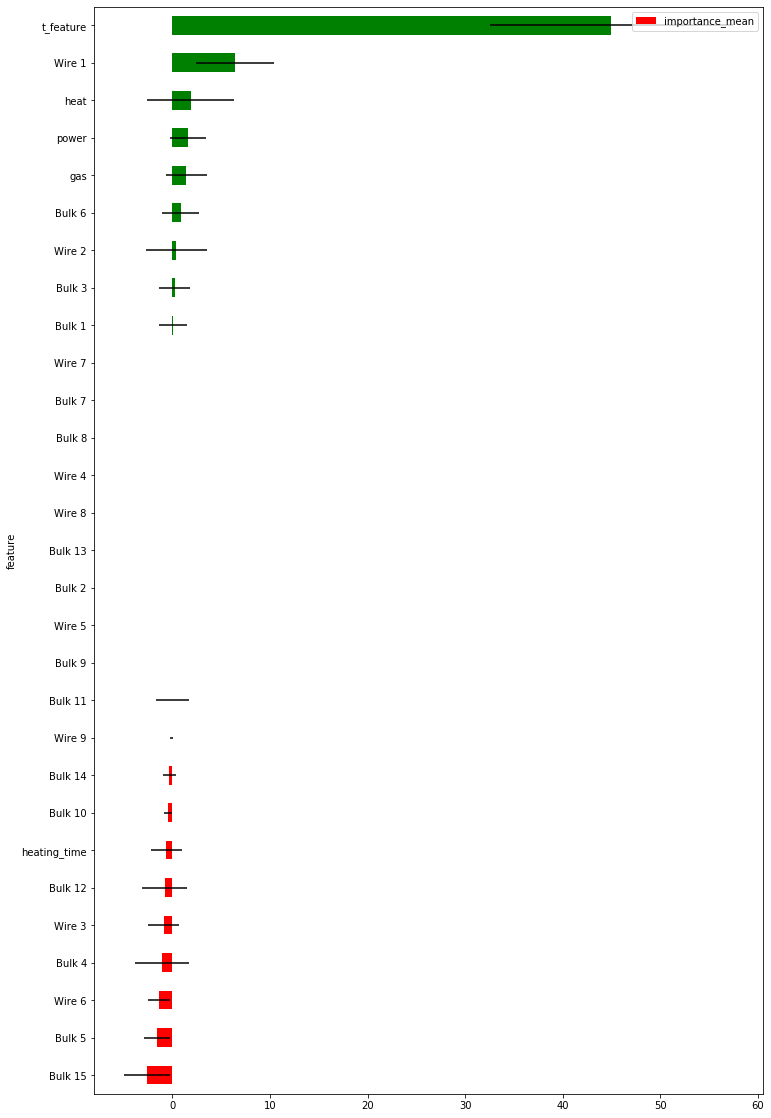

In [40]:
sample_df = df_prom.sample(frac=0.7, random_state=0)

dataset = Dataset(df=sample_df, target="t_target", features=[col for col in df_prom.columns if col != "t_target"])
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_squared_error")
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 20))

Выходит наиболее значимым признаком является начальная температура(до какой температуры изначально разогрели сталь), также немаловажным фактором окзались проволочные материалы под номерами: 1,3,6 количество теплоты, активная мощность(power), данные о продувке сплава газом, сыпучие материалы под номерами: 6,12,4,5,15. </br>  
Но что же делать с другими признаками? Из тех, что не обладают значимостью, у нас остались проволочные и сыпучие материалы.
Здесь образуется вопрос к бизнесу, либо эти добавки действительно мало используются и не так важны, и тогда мы можем от них отказаться вообще, либо это уникальность нашего набора партий.

## <a id='6'>6. Обучение моделей</a> 
<a href='#head'>[head]</a>

### <a id='6.1'>Классические модели</a> 
<a href='#head'>[head]</a>

In [41]:
target = df_prom['t_target']
features = df_prom.drop('t_target', axis = 1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

In [42]:
model_tree = DecisionTreeRegressor(random_state=42)
model_forest = RandomForestRegressor(random_state=42)
model_linear = LinearRegression()
MAE = make_scorer(mean_absolute_error, greater_is_better = False)

In [43]:
def model_check(model, features, target):
    cross_score = (cross_val_score(model, features, target, cv=5, 
                                        scoring = MAE)).mean()
    return cross_score

In [44]:
def model_score(model1, model2, model3):
    return print('Средняя оценка качества модели "Дерево":', model_check(model1, features_train, target_train), 
                 'Средняя оценка качества модели "Лес":', model_check(model2, features_train, target_train),
                 'Средняя оценка качества модели "Линейная регрессия":', model_check(model3, features_train, target_train),
                 sep='\n')

In [45]:
model_score(model_tree, model_forest, model_linear)

Средняя оценка качества модели "Дерево":
-8.655845868475206
Средняя оценка качества модели "Лес":
-6.2546828536649
Средняя оценка качества модели "Линейная регрессия":
-7.876598093986435


На кросс-валидации наилучшую метрику показал случайный лес, попробуем улчшить этот показатель.

In [46]:
default_forest_model = RandomForestRegressor(random_state=42)
default_forest_model.fit(features_train, target_train)
predictions = default_forest_model.predict(features_test)
default_mae_forest = mean_absolute_error(predictions, target_test)
print('MAE леса по умолчанию: {:.4f}'.format(default_mae_forest))

MAE леса по умолчанию: 6.0853


In [44]:
better_forest_model = RandomForestRegressor(random_state=42, criterion = 'mae')
parametrs = {'n_estimators': range (2, 31, 1), 'max_depth': range (2,16, 1)}
grid = GridSearchCV(better_forest_model, parametrs, scoring = MAE, cv = 5)
grid.fit(features_train, target_train)
print('Результат подбора гиперпараметров для леса:', grid.best_params_)

In [45]:
better_forest_model = RandomForestRegressor(random_state=42, criterion = 'mae', n_estimators = 30, max_depth = 10)
better_forest_model.fit(features_train, target_train)
predictions = better_forest_model.predict(features_test)
better_mae_forest = mean_absolute_error(predictions, target_test)
print('MAE леса: {:.4f}'.format(better_mae_forest))

MAE леса: 6.1389


Теперь попробуем старших товарищей LightGBM и CatBoost

### <a id='6.2'>LightGBM</a> 
<a href='#head'>[head]</a>

In [46]:
lgb_model = lgb.LGBMRegressor()

lgb_model.fit(features_train, target_train)
predictions = lgb_model.predict(features_test)
lgb_mae = mean_absolute_error(predictions, target_test)
print('MAE градиентного бустинга по умолчанию: {:.4f}'.format(lgb_mae))

MAE градиентного бустинга по умолчанию: 6.2416


In [71]:
better_lgb_model = lgb.LGBMRegressor()
parametrs = {'n_estimators': [50, 100, 150, 200], 'max_depth': range (2,30, 1), 'learning_rate': [0.1, 0.3, 0.03], 
             'num_leaves': [100, 200, 300, 400]}
grid_lgb = GridSearchCV(better_lgb_model, parametrs, scoring = MAE, cv = 5)
grid_lgb.fit(features_train, target_train)
param_lgb = grid_lgb.best_params_
print('Результат подбора гиперпараметров градиентного бустинга:', param_lgb, sep='\n')

Результат подбора гиперпараметров градиентного бустинга:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'num_leaves': 100}


In [47]:
better_lgb_model = lgb.LGBMRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 150, num_leaves = 100)
better_lgb_model.fit(features_train, target_train)
predictions = better_lgb_model.predict(features_test)
better_lgb_mae = mean_absolute_error(predictions, target_test)
print('Улучшенное MAE градиентного бустинга: {:.4f}'.format(better_lgb_mae))

Улучшенное MAE градиентного бустинга: 6.0299


### <a id='6.3'>CatBoost</a> 
<a href='#head'>[head]</a>

In [48]:
CB_model = CatBoostRegressor()

CB_model.fit(features_train, target_train)
predictions = CB_model.predict(features_test)
CB_mae = mean_absolute_error(predictions, target_test)
print('MAE CatBoost по умолчанию: {:.2f}'.format(CB_mae))

0:	learn: 15.9909097	total: 50.8ms	remaining: 50.7s
1:	learn: 15.7816195	total: 54.6ms	remaining: 27.2s
2:	learn: 15.5381069	total: 58.1ms	remaining: 19.3s
3:	learn: 15.3045285	total: 60.6ms	remaining: 15.1s
4:	learn: 15.0776274	total: 129ms	remaining: 25.7s
5:	learn: 14.8548355	total: 132ms	remaining: 21.9s
6:	learn: 14.6458158	total: 135ms	remaining: 19.1s
7:	learn: 14.4511047	total: 143ms	remaining: 17.7s
8:	learn: 14.2534564	total: 226ms	remaining: 24.9s
9:	learn: 14.0910102	total: 229ms	remaining: 22.7s
10:	learn: 13.9033065	total: 232ms	remaining: 20.9s
11:	learn: 13.7157836	total: 234ms	remaining: 19.3s
12:	learn: 13.5540029	total: 238ms	remaining: 18s
13:	learn: 13.3749434	total: 325ms	remaining: 22.9s
14:	learn: 13.2306706	total: 328ms	remaining: 21.5s
15:	learn: 13.0838944	total: 331ms	remaining: 20.3s
16:	learn: 12.9280032	total: 334ms	remaining: 19.3s
17:	learn: 12.7855577	total: 338ms	remaining: 18.4s
18:	learn: 12.6606672	total: 422ms	remaining: 21.8s
19:	learn: 12.525761

In [70]:
better_CB_model = CatBoostRegressor(silent = True)
parametrs = {'n_estimators': [100, 200, 300], 'max_depth': range (2,16, 1), 'learning_rate': [0.1, 0.3]}
grid_CB = GridSearchCV(better_CB_model, parametrs, scoring = MAE, cv = 5)
grid_CB.fit(features_train, target_train)
CB_params = grid_CB.best_params_
print('Результат подбора гиперпараметров CatBoost:', CB_params)

Результат подбора гиперпараметров CatBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


Результат подбора гиперпараметров CatBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

In [50]:
better_CB_model = CatBoostRegressor(silent = True, learning_rate = 0.1, max_depth = 5, n_estimators = 300)
better_CB_model.fit(features_train, target_train)
predictions = better_CB_model.predict(features_test)
better_CB_mae = mean_absolute_error(predictions, target_test)
print('Улучшенное MAE CatBoost: {:.4f}'.format(better_CB_mae))

Улучшенное MAE CatBoost: 5.9035


Мы достигли желаемой метрики.

## <a id='7'>7. Отчет</a> 
<a href='#head'>[head]</a>

Выявлены наиболее значимые признаки, влияющие на конечную температуру, это: начальная температура, проволочные материалы под номерами: 1,3,6 количество теплоты, активная мощность, данные о продувке сплава газом, сыпучие материалы под номерами: 6,12,4,5,15. Оставшиеся проволочные и сыпучие материалы, если не относятся к уникальности нашего набора партий, могут быть рассмотрены бизнесом на предмет их исключения из цикла производства. </br>  
Основной рекомендацией будет: сделать акцент на управлении подогревом графитовыми электродами до начальной температуры.
</br>  
Ключевым шагом к решению задачи был правильный срез целевого признака - последнего замера и похожего признака - первый замер(наиболее значимый признак), необходимо было правильно разделить, а также убрать те варианты, где осуществлялся только первый замер, также важным шагом было создание новго признака, в части правильности его вычисления, с учетом итераций внутри одной партии. </br>  
Итоговая модель CatBoost(learning_rate = 0.1, max_depth = 5, n_estimators = 300) с MAE: 5.9035

Соответствие изначальному плану:
- [x] Выполнить предобработку данных
- [x] Проанализировать возможность выявления новых признаков (создан признак heat).
- [x] Выбрать признаки, которые будут участвовать в обучении (data_wire_time, data_bulk_time были, Начало нагрева дугой, Конец нагрева дугой, Реактивная мощность исключены).
- [x] Проанализировать распределение, наличие выбросов у признаков, принять решение об участии выбросов в обучении модели, выбросы найдены, получены 2 датасета - с выбросами и без, первый показал себя отлично.
- [x] Обучить классические модели регрессии, выбрать лучшую по дефолтным настройкам, подобрать гиперпараметры для лучшей. Обучить модели CatBoost, LightGBM, подобрать гиперпараметры.
- [x] Выбрать наиболее подходящую по метрике.
- [x] Сделать выводы, написать отчет.